# Boilerplate

In [1]:
# python internal 
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
print(os.getcwd())
import random
import re
import socket
print(socket.gethostname())
import shutil
import subprocess
import sys
# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta
# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

/mnt/home/pleung/projects/bistable_bundle/r3/hinges
dig100


# Flo's original approach:
4. now it gets even worse. I use`/home/flop/switch/5thround/DHRs/loops/score_to_loop.ipynb` to generate cmds for loop closure. have a look, and then we should probably talk about it. it is messy.
	
basically I first try to find loops that match the original DHR, for example
in: `/home/flop/switch/5thround/DHRs/loops/match_orig_d6_04/`

because this doesn't work for all of them, I also re-loop the original DHRs,
also sampling truncations and extensions of the helices before and after the
new loop

i exhaustively did that for all dhrs in my input set: 
`/home/flop/switch/5thround/DHRs/loops/x_ind_all_te`

then I try to find loops in the new states that match the outputs of the state
x relooping: `/home/flop/switch/5thround/DHRs/loops/match_ind_d6/`

# I will follow Flo's looping procedure with some changes.
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.
I will try the following hierarchy of closure methods: 
1. close using identical length loop and no adjustment with connect chains mover (CCM) at 0.8 RMS (total length and SS match)
2. constrained remodel with `BluePrintBDR`, forcing SS agreement with parent but allowing any `ABEGO` (total length and SS match)
These methods seem to get around 75% closure, which I think will be pretty workable.  


Things that aren't at the moment worthwhile:
1. close using identical length loop and +/-2 res adjustment on each side with CCM at 0.4 RMS (total length match, potential SS mismatch)  
This one has issues with the adjustments resulting in unexpected lengths of the finished design 
2. less constrained remodel with `BluePrintBDR`, allowing any secondary structure and any `ABEGO` (total length match, potential SS mismatch)  
This one doesn't seem like it would get significantly more closures, for approximately 40% more compute

# Make functions for looping and labeling to assist downstream penultimate design step

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init
from typing import *

@requires_init
def load(silent: str, **kwargs) -> Generator[str, PackedPose, None]:
    """
    Requires init. Because of some issues with silent energies, if your energy 
    is supposed to be a string but is an empty string  (""),
    it will be set to a float value of 0.0
    @pleung
    """
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.rosetta.core.io.silent import SilentFileOptions, SilentFileData
    from pyrosetta.rosetta.core.pose import Pose
    if silent == None:
        silent = kwargs["-in:file:silent"]
    else:
        pass
    options = SilentFileOptions() 
    sfd = SilentFileData(options) # the part that requires init
    sfd.read_file(silent)
    for tag in sfd.tags():
        ss = sfd.get_structure(tag)
        ss_energies = list(ss.energies())
        pose = Pose()
        ss.fill_pose(pose)
        pose.pdb_info().name(tag)
        for energy in ss_energies:
            key = energy.name() 
            # takes advantage of string_value returning "" for true floats
            if energy.string_value() is not "":
                value = energy.string_value() 
            else: # if your energy is supposed to be an empty string it will be set to 0.0 here
                value = energy.value()
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
        ppose = io.to_packed(pose)
        yield ppose
        
def loop_match(ppose: PackedPose, **kwargs) -> PackedPose:
    """
    Match loop length, total length and DSSP with parent. Strictest method of closure.
    TODO make rmsd kwarg?    
    """
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    scores = deepcopy(ppose.pose.scores)
    # get parent from ppose, get loop length from parent length - ppose length
    parent_length = int(scores["parent_length"])
    length = int(parent_length - len(ppose.pose.residues))
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" /> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>          
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <MOVERS>
            <ConnectChainsMover name="closer" 
                chain_connections="[A+B]" 
                loopLengthRange="{length},{length}" 
                resAdjustmentRangeSide1="0,0" 
                resAdjustmentRangeSide2="0,0" 
                RMSthreshold="0.8"/>
            <SwitchChainOrder name="rechain" chain_order="1"/>
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <PROTOCOLS>
            <Add mover_name="closer"/>
            <Add mover_name="rechain"/>
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(length=length)
    closer = SingleoutputRosettaScriptsTask(xml)
    try:
        maybe_closed_ppose = closer(ppose.pose.clone())
        closure_type = "loop_match"
    except RuntimeError:
        maybe_closed_ppose = io.to_pose(ppose.pose.clone())
        closure_type = "not_closed"
    maybe_closed_pose = io.to_pose(maybe_closed_ppose)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(maybe_closed_pose, "closure_type", closure_type)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(maybe_closed_pose, key, value)
    final_ppose = io.to_packed(maybe_closed_pose)
    return final_ppose


def strict_remodel(ppose: PackedPose, **kwargs) -> PackedPose:
    """
    DSSP and SS agnostic in principle but in practice more or less matches.
    """
    from copy import deepcopy
    import os
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.packed_pose.core import PackedPose
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    
    def strict_remodel_helper(ppose: PackedPose, loop_length:int) -> str:
        import binascii, os
        import pyrosetta
        from pyrosetta.rosetta.core.pose import Pose
        
        def phi_psi_omega_to_abego(phi: float, psi: float, omega: float) -> str:
            """
            From Buwei
            https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
            """
            if psi == None or phi == None: return "X"
            if omega == None: omega = 180

            if abs(omega) < 90:
                return "O"
            elif phi > 0:
                if -100.0 <= psi < 100:
                    return "G"
                else:
                    return "E"
            else:
                if -75.0 <= psi < 50:
                    return "A"
                else:
                    return "B"
            return "X"

        def abego_string(phi_psi_omega: list) -> str:
            """
            From Buwei
            https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
            """
            out = ""
            for x in phi_psi_omega:
                out += phi_psi_omega_to_abego(x[0], x[1], x[2])
            return out

        def get_torsions(pose: Pose) -> list:
            """
            From Buwei
            https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
            """
            torsions=[]
            for i in range(1, pose.total_residue() + 1):
                phi = pose.phi(i)
                psi = pose.psi(i)
                omega = pose.omega(i)
                if i == 1:
                    phi = None
                if i == pose.total_residue():
                    psi = None
                    omega = None
                torsions.append((phi, psi, omega))
            return torsions
        
        pose = ppose.pose.clone()
        tors = get_torsions(pose)
        abego_str = abego_string(tors)
        dssp = pyrosetta.rosetta.protocols.simple_filters.dssp(pose)
        # name blueprint a random 32 long hex string
        filename = str(binascii.b2a_hex(os.urandom(16)).decode("utf-8")) + ".bp"
        # write a temporary blueprint file
        with open(filename, "w+") as f:
            end1, begin2 = ppose.pose.chain_end(1), ppose.pose.chain_begin(2)
            end2 = ppose.pose.chain_end(2)
            for i in range(1, end1+1):
                if i == end1: 
                    print(
                        str(i), 
                        ppose.pose.residue(i).name1(), 
                        dssp[i-1]+"X",
                        "R",
                        file=f,
                    )
                else:
                    print(
                        str(i),
                        ppose.pose.residue(i).name1(), 
                        dssp[i-1]+abego_str[i-1], 
                        ".", 
                        file=f,
                    )
            for i in range(loop_length):
                print("0", "V", "LX", "R", file=f) # TODO DX is bad, causes rare error sometimes 
            for i in range(begin2, end2+1):
                if i == begin2: 
                    print(
                        str(i), 
                        ppose.pose.residue(i).name1(), 
                        dssp[i-1]+"X",
                        "R",
                        file=f,
                    )
                else:
                    print(
                        str(i),
                        ppose.pose.residue(i).name1(), 
                        dssp[i-1]+abego_str[i-1], 
                        ".", 
                        file=f,
                    )
        return filename
    
    # ensure pose still needs to be closed
    if ppose.pose.num_chains() == 1:
        final_ppose = io.to_packed(ppose.pose.clone())
        return final_ppose
    else:
        scores = deepcopy(ppose.pose.scores)
        # get parent from ppose, get loop length from parent length - ppose length
        parent_length = int(scores["parent_length"])
        length = int(parent_length - len(ppose.pose.residues))
        bp = strict_remodel_helper(ppose, length)
        xml = """
        <ROSETTASCRIPTS>
            <SCOREFXNS>
                <ScoreFunction name="sfxn1" weights="fldsgn_cen">
                    <Reweight scoretype="hbond_sr_bb" weight="1.0" />
                    <Reweight scoretype="hbond_lr_bb" weight="1.0" />
                    <Reweight scoretype="atom_pair_constraint" weight="1.0" />
                    <Reweight scoretype="angle_constraint" weight="1.0" />
                    <Reweight scoretype="dihedral_constraint" weight="1.0" />
                </ScoreFunction>
            </SCOREFXNS>
            <RESIDUE_SELECTORS>          
            </RESIDUE_SELECTORS>
            <TASKOPERATIONS>
            </TASKOPERATIONS>
            <SIMPLE_METRICS>
            </SIMPLE_METRICS>
            <MOVERS>
                <BluePrintBDR name="bdr" 
                blueprint="{bp}" 
                use_abego_bias="0" 
                use_sequence_bias="0" 
                rmdl_attempts="20"
                scorefxn="sfxn1"/>
                #RemodelMover name="bdr" blueprint="{bp}"/>      
            </MOVERS>
            <FILTERS>
            </FILTERS>
            <PROTOCOLS>
                <Add mover_name="bdr"/>
            </PROTOCOLS>
        </ROSETTASCRIPTS>
        """.format(bp=bp)
        strict_remodel = SingleoutputRosettaScriptsTask(xml)
        # try to close once. returns None if fail
        maybe_closed_ppose = strict_remodel(ppose.pose.clone())
        for i in range(5):
            print(f"attempt: {i}")
            if maybe_closed_ppose is not None: # check if it worked
                closure_type = "strict_remodel"
                break
            else: # try again if it didn't
                maybe_closed_ppose = strict_remodel(ppose.pose.clone())
        os.remove(bp) # cleanup tree
        if maybe_closed_ppose is not None:
            closure_type = "strict_remodel" 
            maybe_closed_pose = io.to_pose(maybe_closed_ppose)
            pyrosetta.rosetta.core.pose.setPoseExtraScore(maybe_closed_pose, "closure_type", closure_type)
            final_ppose = io.to_packed(maybe_closed_pose)            
        else:
            final_ppose = io.to_packed(ppose.pose.clone())
        return final_ppose
    
    
def label(ppose: PackedPose, **kwargs) -> PackedPose:
    """
    TODO this seems to have the expected behavior.
    """
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    from pyrosetta.rosetta.core.pose import Pose
    from pyrosetta.rosetta.core.select import get_residues_from_subset
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects 
    
    def phi_psi_omega_to_abego(phi: float, psi: float, omega: float) -> str:
        """
        From Buwei
        https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
        """
        if psi == None or phi == None: return "X"
        if omega == None: omega = 180

        if abs(omega) < 90:
            return "O"
        elif phi > 0:
            if -100.0 <= psi < 100:
                return "G"
            else:
                return "E"
        else:
            if -75.0 <= psi < 50:
                return "A"
            else:
                return "B"
        return "X"
    
    def abego_string(phi_psi_omega: list) -> str:
            """
            From Buwei
            https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
            """
            out = ""
            for x in phi_psi_omega:
                out += phi_psi_omega_to_abego(x[0], x[1], x[2])
            return out

    def get_torsions(pose: Pose) -> list:
        """
        From Buwei
        https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
        """
        torsions=[]
        for i in range(1, pose.total_residue() + 1):
            phi = pose.phi(i)
            psi = pose.psi(i)
            omega = pose.omega(i)
            if i == 1:
                phi = None
            if i == pose.total_residue():
                psi = None
                omega = None
            torsions.append((phi, psi, omega))
        return torsions
        
    def find_vv(seq):
        indices = []
        seq_minus_one = seq[:-1]
        for i, char in enumerate(seq_minus_one):
            if (char == seq[i+1]) and (char == "V"):
                indices.append(i+1)
            else:
                pass
        # rosetta sequence indexes begin at 1
        true_indices = [str(x+1) for x in indices]
        return true_indices
    
    scores = deepcopy(ppose.pose.scores)
    if ppose.pose.num_chains() != 1: # ensure pose has been closed, 
        new_loop_str = "0,0"
        labeled_pose = ppose.pose.clone()
    else:
        seq = str(ppose.pose.sequence())
        vv_indices = ",".join(find_vv(seq))
        pivot_helix = int(scores["pivot_helix"])
        pre_break_helix = int(scores["pre_break_helix"])
        # get helix indices for the pre and post break helices
        lower = pre_break_helix
        upper = pre_break_helix + 1
        xml = """
        <ROSETTASCRIPTS>
            <SCOREFXNS>
                <ScoreFunction name="sfxn" weights="beta_nov16" /> 
            </SCOREFXNS>
            <RESIDUE_SELECTORS>
                <SSElement name="middle" selection="{lower},H,E" to_selection="{upper},H,S" chain="A" reassign_short_terminal_loop="2" />
                <Index name="polyval_all" resnums="{vv_indices}" />
                <And name="polyval" selectors="middle,polyval_all" />
                <PrimarySequenceNeighborhood name="entire_val" selector="polyval" lower="5" upper="5" />
                <SecondaryStructure name="loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" use_dssp="true" ss="L"/>
                <And name="new_loop_center" selectors="entire_val,loop" />
                <PrimarySequenceNeighborhood name="entire_new_loop_broad" selector="new_loop_center" lower="5" upper="5" />
                <ResidueName name="isval" residue_name3="VAL" />
                <And name="entire_new_loop" selectors="entire_new_loop_broad,isval" />
            </RESIDUE_SELECTORS>
            <TASKOPERATIONS>
            </TASKOPERATIONS>
            <SIMPLE_METRICS>
            </SIMPLE_METRICS>
            <MOVERS>
                <AddResidueLabel name="add_loop_label" residue_selector="entire_new_loop" label="new_loop" />  
            </MOVERS>
            <FILTERS>
            </FILTERS>
            <PROTOCOLS>
                <Add mover="add_loop_label" />
            </PROTOCOLS>
            #OUTPUT scorefxn="sfxn" />
        </ROSETTASCRIPTS>
        """.format(lower=lower, upper=upper, vv_indices=vv_indices)
        labeled = SingleoutputRosettaScriptsTask(xml)
        xml_obj = XmlObjects.create_from_string(xml)
        entire_new_loop_sel = xml_obj.get_residue_selector("entire_new_loop")
        labeled_ppose = labeled(ppose.pose.clone())
        labeled_pose = io.to_pose(labeled_ppose)
        new_loop_resis = list(get_residues_from_subset(entire_new_loop_sel.apply(labeled_pose)))
        new_loop_str = ",".join(str(resi) for resi in new_loop_resis)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, "new_loop_resis", new_loop_str)
    total_length = len(labeled_pose.residues)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, "total_length", total_length)
    dssp = pyrosetta.rosetta.protocols.simple_filters.dssp(labeled_pose)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, "dssp", dssp)
    tors = get_torsions(labeled_pose)
    abego_str = abego_string(tors)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, "abego_str", abego_str)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, key, value)
    final_ppose = io.to_packed(labeled_pose)
    return final_ppose

# Setup Dask
Trying a adaptive SLURMCluster. to see the dashboard, forward port `8787` to `8000`:  
`local$ ssh -L 8000:localhost:8787 $USER@$HOSTNAME`  
now, the web UI is visible at `localhost:8000`  
if you're using a local cluster make sure the node this notebook is on has the same 
number of workers as cores

In [3]:
!echo $HOSTNAME
!echo $USER

dig84
pleung


In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       processes=1,
                       job_cpu=1,
                       memory="8GB",
                       queue="medium",
                       walltime="23:30:00",
                       death_timeout=600,
                      )
print(cluster.job_script())
# scale between 0 and 200 workers as needed
cluster.adapt(minimum=0, maximum=200) 
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=8G
#SBATCH -t 23:30:00

/home/pleung/.conda/envs/cereal/bin/python -m distributed.cli.dask_worker tcp://172.16.131.130:45959 --nthreads 1 --memory-limit 8.00GB --name name --nanny --death-timeout 600 --local-directory $TMPDIR/dask --no-nanny --no-dashboard



Client Scheduler: tcp://172.16.131.130:45959 Dashboard: http://172.16.131.130:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
# client.close(); cluster.close()

# Set command line options, make tasks and submit to client
previously used `-indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5`

In [6]:
import logging
import pyrosetta.distributed.io as io
from pyrosetta.distributed.cluster.core import PyRosettaCluster

logging.basicConfig(level=logging.INFO)
silents = glob(os.path.join(os.getcwd(), "02_silents/states.silent"))

options = { 
    "-out:level": "300",
    "-in:file:silent_struct_type": "binary",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
}

def create_tasks(silents, options):
    for silent in silents:
        tasks = {"options": "-corrections::beta_nov16 true"}
        tasks["extra_options"] = options
        tasks["set_logging_handler"] = "interactive"
        tasks["-in:file:silent"] = silent
        yield tasks
        
if not os.getenv("DEBUG"):
    output_path = os.path.join(os.getcwd(), "03_enumerate_loops")
    PyRosettaCluster(
        tasks=create_tasks(silents, options),
        client=client,
        scratch_dir=output_path,
        output_path=output_path,
    ).distribute(protocols=[load, loop_match, strict_remodel, label])

`conda env export --prefix /home/pleung/.conda/envs/cereal > environment.yml`
to reproduce this simulation later.
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/cereal/lib/python3.7/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


https://docs.anaconda.com/anaconda/install



CommClosedError: in <closed TCP>: Stream is closed

# Look at scores
There is certainly a less embarrassing way to do this but at least this way is vectorized, so it should scale very well

In [7]:
def read_scorefile(scores):
    import pandas as pd
    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores
    
output_path = os.path.join(os.getcwd(), "03_enumerate_loops")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,abego_str,bb_clash,closure_type,ddg,dslf_fa13,dssp,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,...,sc_int,scaffold,score,score_A,score_B,score_per_res,sfxn_used,shift,total_length,total_score
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/03_enumerate_loops/decoys/0000/2021.02.15.23.14.25.540643_de59a51b2a8f41d3a4a57313d000c71d.pdb.bz2,XAAAAAAAAAAAAAAAAAABGAEAAAAAAAAAAAAAAAAAAAAAAA...,53.938000,loop_match,-93.216003,0.0,LHHHHHHHHHHHHHHHHHHLLLLHHHHHHHHHHHHHHHHHHHHHHH...,-1227.466435,170.723293,171.769801,194.552948,...,0.744,TH_DHR,0.0,-138.059998,-140.498993,-2.887,beta_nov16,0.0,200.0,244.142783
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/03_enumerate_loops/decoys/0000/2021.02.15.23.14.25.540643_062db7078329482eb929a204d261708d.pdb.bz2,XAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAABABAAAAAA...,37.347000,not_closed,-64.490997,0.0,LHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHHLLLLHHHHHH...,-940.690979,21.844999,122.996002,166.830994,...,0.782,DHR,0.0,-107.349998,-111.526001,-2.756,beta_nov16,-6.0,156.0,-429.898010
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/03_enumerate_loops/decoys/0000/2021.02.15.23.14.25.540643_978a65a7ec1d484aa11355ed29b88bbf.pdb.bz2,XAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAA...,76.821999,strict_remodel,-70.956001,0.0,LHHHHHHHHHHHHHHHHHHHHHHHHHLLHHHHHHHHHHHHHHHHHH...,-1394.620972,31.618000,197.382004,255.011993,...,0.775,DHR,0.0,-159.707001,-184.475998,-2.892,beta_nov16,1.0,228.0,-650.601990
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/03_enumerate_loops/decoys/0000/2021.02.15.23.14.25.540643_f8115bc8ca4246e794bdadc1f76b9890.pdb.bz2,XAAAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAGBBAAAA...,55.573002,loop_match,-69.250000,0.0,LHHHHHHHHHHHHHHHHHLLLLHHHHHHHHHHHHHHHHHLLLHHHH...,-1061.550354,157.408507,169.237744,191.189732,...,0.719,TH_DHR,0.0,-106.786003,-129.410004,-2.730,beta_nov16,0.0,172.0,1274.881609
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/03_enumerate_loops/decoys/0000/2021.02.15.23.14.25.540643_93c855dcb14a4d78884ca81f3bc4fd27.pdb.bz2,XAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAABAB...,51.785999,strict_remodel,-63.084999,0.0,LHHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHHHHHHLLL...,-1110.192017,40.305000,192.296005,211.195999,...,0.767,DHR,0.0,-100.501999,-92.371002,-2.375,beta_nov16,-7.0,184.0,-427.526001


In [8]:
len(scores_df)

1838

<AxesSubplot:ylabel='None'>

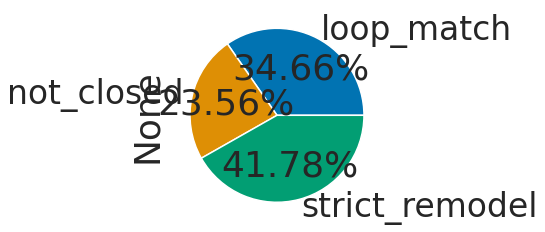

In [9]:
# length = scores_df.query("closure_type == 'length_match'")
sns.set(
    context="talk",
    font_scale=2, # make the font larger; default is pretty small
    style="ticks", # make the background white with black lines
    palette="colorblind" # a color palette that is colorblind friendly!
)
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
scores_df.groupby("closure_type").size().plot(kind="pie", autopct="%1.2f%%") #, ax=ax1)
# not_bad_df.groupby("scaffold").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
# ax1.set_ylabel("Pre selection")
# ax2.set_ylabel("Post selection")
# plt.tight_layout()


In [ ]:
# closed = scores_df.query("'closure_type' != 'not_closed'")

for i, row in scores_df.iterrows():
    if row["closure_type"] != "not_closed":
        print(len(row["abego_str"]) == int(row["parent_length"]))
#         print(row)

In [ ]:
scores_df.columns

In [ ]:
thrs = scores_df[scores_df["scaffold"].str.contains("THR")]
dhrs = scores_df[scores_df["scaffold"].str.match("DHR")]
th_dhrs = scores_df[scores_df["scaffold"].str.match("TH_DHR")]

In [ ]:
sns.set(
    context="talk",
    font_scale=2, # make the font larger; default is pretty small
    style="ticks", # make the background white with black lines
    palette="colorblind" # a color palette that is colorblind friendly!
)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(30, 20), tight_layout=False)
scores_df.groupby("closure_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
thrs.groupby("closure_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
dhrs.groupby("closure_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax3)
th_dhrs.groupby("closure_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax4)
ax1.set_ylabel("All")
ax2.set_ylabel("THRs")
ax3.set_ylabel("DHRs")
ax4.set_ylabel("TH_DHRs")
plt.savefig("figs/03_looping_counts_by_scaffold.png")

In [ ]:
scores_df["pivot_helix"] = scores_df["pivot_helix"].astype(float).astype(int)
scores_df["pre_break_helix"] = scores_df["pre_break_helix"].astype(float).astype(int)
scores_df["shift"] = scores_df["shift"].astype(float).astype(int)

In [ ]:
# from matplotlib import ticker
# from matplotlib.ticker import MultipleLocator, FormatStrFormatter
# sns.set(
#     context="talk",
#     font_scale=2, # make the font larger; default is pretty small
#     style="ticks", # make the background white with black lines
#     palette="colorblind" # a color palette that is colorblind friendly!
# )

# order = list(set(scores_df["shift"].values))
# order.sort()

# fig = plt.figure(figsize=(20,10), tight_layout=True)
# pivot_order = [4, 5, 6, 7]
# ax = sns.boxplot(
#     x="shift", y="score_per_res", data=scores_df,
#     order= order, showfliers=False,
#     hue="pivot_helix", hue_order=pivot_order,
# )
# ax.legend(loc="upper right")
# ax.set_ylim(-5, 0)
# sns.despine()
# plt.setp(ax.get_legend().get_title(), fontsize='24')
# plt.xticks(rotation=90)
# plt.savefig("figs/02_shift_vs_score_per_res_groupby_pivot.png")

# Parallel unzipping, relabeling and packing into a silent of all selected designs
Method maintains score info

In [ ]:
import pyrosetta.distributed.io as io
from pyrosetta.distributed.packed_pose.core import PackedPose

def unpack_add_scores_repack(bz2file:str, scores:dict) -> PackedPose:
    import bz2
    import os
    import pyrosetta
    import pyrosetta.distributed.io as io
    with open(bz2file, "rb") as f:
        ppose = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
    pose = io.to_pose(ppose)
    basename =  os.path.basename(bz2file.replace(".pdb.bz", "", 1))
    pose.pdb_info().name(basename)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    final_ppose = io.to_packed(pose)
    return final_ppose

if not os.getenv("DEBUG"):
    future_pposes = []
    for i, bz2file in enumerate(scores_df.index, start=1): # TODO
        # decompress from bz2, add score info and pack
        scores = dict(scores_df.loc[bz2file])
        if scores["closure_type"] != "not_closed":
            future_ppose = client.submit(unpack_add_scores_repack, bz2file, scores)
            future_pposes.append(future_ppose)
    pposes = []
    for future in tqdm(future_pposes):
        pposes.append(future.result())

out_path = os.path.join(os.getcwd(), "03_silents")
silent_name = "closed.silent"

os.makedirs(out_path, exist_ok=True)
io.to_silent(pposes, os.path.join(out_path, silent_name))
msg = """
out_path: {out_path}
packed {i} poses
""".format(out_path=out_path, i=i)
print(msg)

In [ ]:
client.close(); cluster.close()